In [26]:
import os
import shutil
from pathlib import Path

import jax.random as jr
import jax.numpy as jnp
from omegaconf import OmegaConf
import matplotlib.pyplot as plt

from cohlib.utils import pickle_open
from cohlib.jax.dists import sample_from_gamma
from cohlib.jax.observations import add0



In [27]:
def clean_dir(path):
    _dir = Path(path)
    for i, exp in enumerate(_dir.glob('*')):
        exp_path = Path(exp)
        contents = []
        for f in exp_path.glob('*'):
            contents.append(os.path.split(f)[1])
        if 'res.pickle' not in contents: 
            shutil.rmtree(exp_path)
            print('Removing unfinished experiment')

In [28]:
def check_attrs(cfg, lcfg_attrs, mcfg_attrs, ocfg_attrs):    
    lcfg_check = [cfg.latent.get(k, None) == v for k, v in lcfg_attrs.items()]
    mcfg_check = [cfg.model.get(k, None) == v for k, v in mcfg_attrs.items()]
    ocfg_check = [cfg.obs.get(k, None) == v for k, v in ocfg_attrs.items()]

    check = jnp.all(jnp.array(lcfg_check + mcfg_check + ocfg_check))
    return check

def filter_load_results(paths, lcfg_attrs, mcfg_attrs, ocfg_attrs):
    sel_paths = []
    for path in paths:
        _dir = Path(path)
        for i, exp in enumerate(_dir.glob('*')):
            cfg_path = os.path.join(exp, '.hydra/config.yaml')
            cfg = OmegaConf.load(cfg_path)

            if check_attrs(cfg, lcfg_attrs, mcfg_attrs, ocfg_attrs):
                sel_paths.append(exp)

    assert len(sel_paths) > 0
    print(f'{len(sel_paths)} paths found meeting critera')

    results = []
    for path in sel_paths:
        cfg_path = os.path.join(path, '.hydra/config.yaml')
        cfg = OmegaConf.load(cfg_path)

        res = pickle_open(os.path.join(path, 'res.pickle'))
        res['cfg'] = cfg
        results.append(res)

    return results


def filter_loaded(loaded, lcfg_attrs, mcfg_attrs, ocfg_attrs):
    filtered = [r for r in loaded if check_attrs(r['cfg'], lcfg_attrs, mcfg_attrs, ocfg_attrs)]
    if len(filtered) == 0:
        print("No results in list to filter.")
    elif len(filtered) == 1:
        print("Returned single result.")
        return filtered[0]
    else:
        print("Multiple results found.")
        return filtered

In [29]:
def transform(spec, dB=True):
    if dB is True:
        return 10*jnp.log10(spec+1e-15)
    else:
        return spec

In [67]:
alpha = 200
lcfg_attrs = {'scale': 1e4}

mcfg_attrs = {'init': 'true-init',
              'init_mod': 0.01,
              'true_to_flat': 'target',
              'scale_init': 1e4}

ocfg_attrs = {'obs_type': 'pp_relu',
              'alpha': alpha}

In [68]:
res_paths = ['/projectnb/stephenlab/jtauber/cohlib/hydra/pp_relu_obs/outputs/2024-09-16']
for res_path in res_paths:
    clean_dir(res_path)

results = filter_load_results(res_paths, lcfg_attrs, mcfg_attrs, ocfg_attrs)
Ls = sorted([r['cfg'].latent.L for r in results])
print(Ls)

3 paths found meeting critera
[10, 25, 50]


Returned single result.


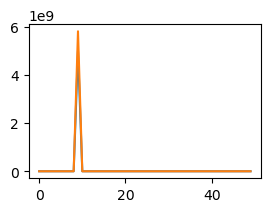

In [69]:
L = Ls[1]
lsel = {'L': L}
res = filter_loaded(results, lsel, {}, {})

gamma_true = res['gamma_true_full']
gamma_est = res['gamma']
gamma_init = res['gamma_init']
nz = jnp.arange(50)
k = 0
fig,ax = plt.subplots(figsize=(3,2))
ax.plot(gamma_true[nz,k,k].real)
ax.plot(gamma_est[:,k,k].real)
# ax.plot(gamma_init[:,k,k].real)
# plt.ylim([0,1e6])

Returned single result.
Returned single result.
Returned single result.


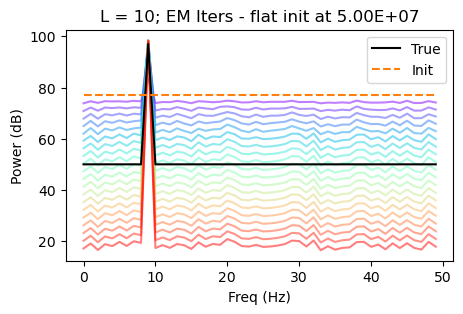

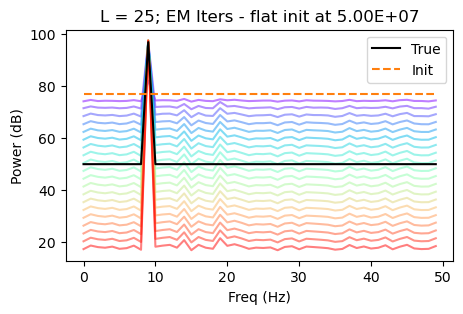

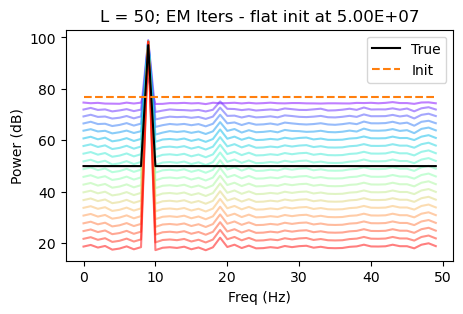

In [70]:
for L in Ls:
    lsel = {'L': L}
    res = filter_loaded(results, lsel, {}, {})

    dB = True
    num_iters = 20
    color = plt.cm.rainbow(jnp.linspace(0, 1, num_iters))
    skip = 0
    fig, ax = plt.subplots(figsize=(5,3))
    for r, c in enumerate(color[skip:]):
        S_r = transform(res['track']['gamma'][r+skip][:,k,k].real, dB=dB)
        ax.plot(S_r, color=c, alpha=0.5)
    S_init = transform(res['gamma_init'][:,k,k].real, dB=dB)
    S_true = transform(gamma_true[nz,k,k].real, dB=dB)
    ax.plot(S_true, color='k', label='True')
    ax.plot(S_init, color='tab:orange', linestyle='--', label='Init')
    ax.set_xlabel('Freq (Hz)')
    if dB is False:
        ax.set_ylabel('Power')
    else: 
        ax.set_ylabel('Power (dB)')
    ax.set_title(f'L = {L}; EM Iters - flat init at {res["cfg"].model.init_mod * gamma_true[9,k,k].real:.2E}')
    ax.legend()

In [50]:
# Great - much better behavior

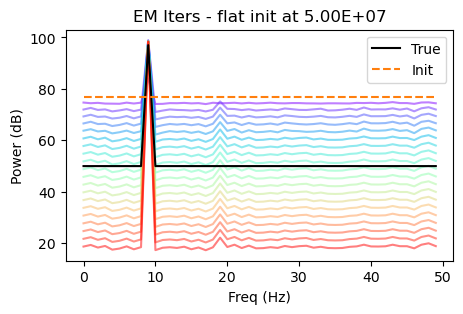

In [71]:
dB = True
num_iters = 20
color = plt.cm.rainbow(jnp.linspace(0, 1, num_iters))
fig, ax = plt.subplots(figsize=(5,3))
for r, c in enumerate(color):
    S_r = transform(res['track']['gamma'][r][:,k,k].real, dB=dB)
    ax.plot(S_r, color=c, alpha=0.5)
S_init = transform(res['gamma_init'][:,k,k].real, dB=dB)
S_true = transform(gamma_true[nz,k,k].real, dB=dB)
ax.plot(S_true, color='k', label='True')
ax.plot(S_init, color='tab:orange', linestyle='--', label='Init')
ax.set_xlabel('Freq (Hz)')
if dB is False:
    ax.set_ylabel('Power')
else: 
    ax.set_ylabel('Power (dB)')
ax.set_title(f'EM Iters - flat init at {res["cfg"].model.init_mod * gamma_true[9,k,k].real:.2E}')
ax.legend()

Text(0.5, 1.0, 'Target value with flat init at 5.00E+07')

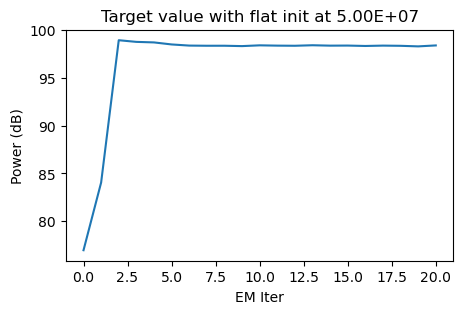

In [72]:
k = 0
skip = 0
init_val = transform(gamma_init[9,k,k].real, dB=dB)
em_target = jnp.array([transform(res['track']['gamma'][r+skip][9,k,k].real, dB=dB) for r in range(num_iters-skip)])
em_target = jnp.insert(em_target, 0, init_val)
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(em_target)
# ax.axhline(transform(gamma_true[9,k,k].real, dB=dB), color='k', linestyle='--', label='True Value')
# ax.legend()
ax.set_xlabel('EM Iter')
if dB is False:
    ax.set_ylabel('Power')
else: 
    ax.set_ylabel('Power (dB)')
ax.set_title(f'Target value with flat init at {res["cfg"].model.init_mod * gamma_true[9,k,k].real:.2E}')

In [73]:
from cohlib.jax.dists import sample_obs
cfg = res['cfg'] 

lseed = cfg.latent.seed
L = cfg.latent.L

zs = sample_from_gamma(jr.key(lseed), gamma_true, L)

zs_0dc = jnp.apply_along_axis(add0, 0, zs)
xs = jnp.fft.irfft(zs_0dc, axis=0)
ocfg = cfg['obs']
zs_0dc = jnp.apply_along_axis(add0, 0, zs)
xs = jnp.fft.irfft(zs_0dc, axis=0)

obs, obs_params = sample_obs(ocfg, xs)

In [74]:
def naive_estimator(spikes, nonzero_inds=None):
    "spikes has shape (time, unit, trial)"
    n_f0 = jnp.fft.rfft(spikes, axis=0)
    n_f = n_f0[1:,:,:]
    naive_est = jnp.einsum('jkl,jil->jkil', n_f, n_f.conj()).mean(-1)

    if nonzero_inds is None:
        return naive_est
    else:
        return naive_est[nonzero_inds, :, :]


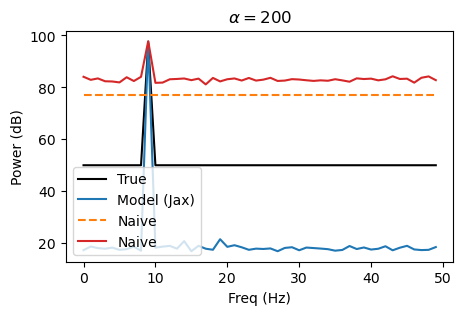

In [77]:
dB = True 
gamma_naive = naive_estimator(obs, nz)
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(transform(gamma_true[nz,k,k].real, dB=dB), color='k', label='True')
ax.plot(transform(gamma_est[:,k,k].real, dB=dB), label='Model (Jax)')
ax.plot(transform(gamma_init[:,k,k].real, dB=dB), linestyle='--', color='tab:orange', label='Naive')
ax.plot(transform(gamma_naive[:,k,k].real * 1e6, dB=dB), color='tab:red', label='Naive')
ax.set_title(r'$\alpha = $' + f'{alpha}')

ax.set_xlabel('Freq (Hz)')
if dB is False:
    ax.set_ylabel('Power')
else: 
    ax.set_ylabel('Power (dB)')
ax.legend()
# ax.set_xlim([8,12])

(0.0, 1.0)

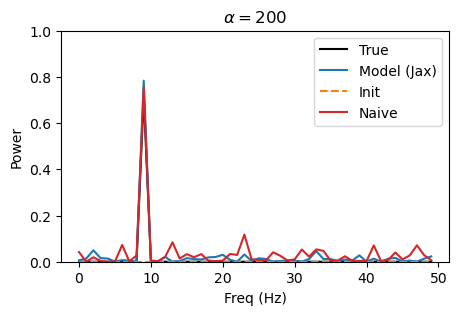

In [76]:
from cohlib.mvcn import thr_coherence
dB = False 
gamma_naive = naive_estimator(obs, nz)
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(thr_coherence(gamma_true[nz,:,:]), color='k', label='True')
ax.plot(thr_coherence(gamma_est[:,:,:]), label='Model (Jax)')
ax.plot(thr_coherence(gamma_init[:,:,:]), linestyle='--', color='tab:orange', label='Init')
ax.plot(thr_coherence(gamma_naive[:,:,:] * 1e6), color='tab:red', label='Naive')
ax.set_title(r'$\alpha = $' + f'{alpha}')

ax.set_xlabel('Freq (Hz)')
if dB is False:
    ax.set_ylabel('Power')
else: 
    ax.set_ylabel('Power (dB)')
ax.legend()
ax.set_ylim([0,1])

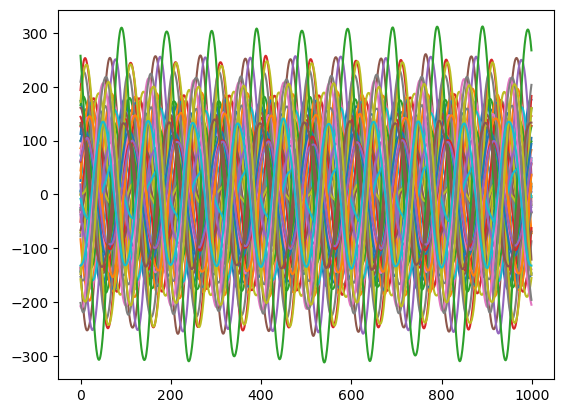

In [57]:
L = xs.shape[-1]
for l in range(L):
    plt.plot(xs[:,0,l])

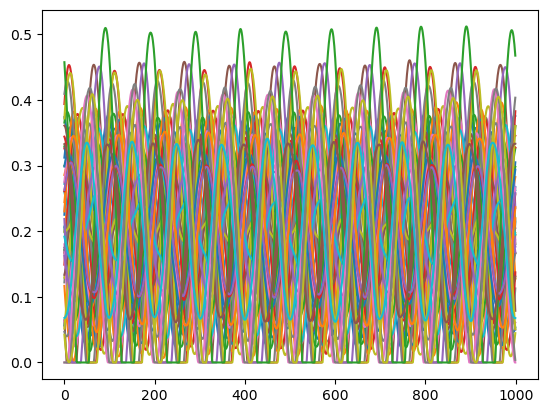

In [58]:
alpha = cfg.obs.alpha
for l in range(L):
    lams = (alpha + xs[:,0,l])*1e-3
    lams = lams.at[lams < 0].set(0)
    plt.plot(lams)

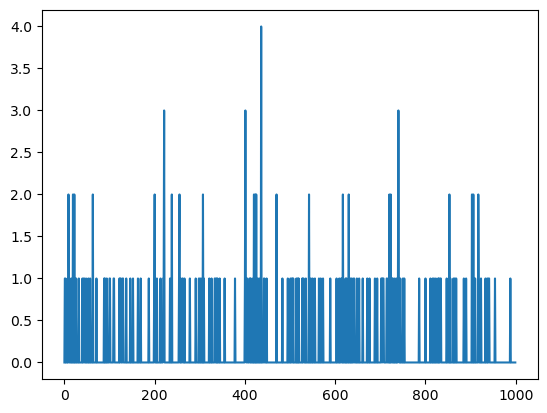

In [48]:
l = 1
plt.plot(obs[:,0,l])

In [18]:
k = 0
# res['track']['gamma'][3][:,k,k].real
# res['gamma_true_full'][:,k,k].real
res['gamma_init'][:,k,k].real

Array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01], dtype=float32)

(0.0, 25.0)

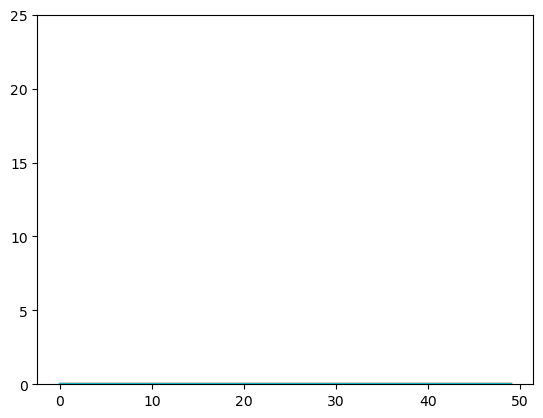

In [10]:
for i, g in enumerate(res['track']['gamma']):
    if i < 10:
    # if i == 0:
        # plt.plot(g[:,k,k].real * 1e-6)
        plt.plot(g[:,k,k].real)
# plt.ylim([520,522])
plt.ylim([0, 25])

# Cool!
Next:
    - Compare to Old
    - Try log link 
    - Play with initilization a bit...
    - Play with alpha 
    - Try K > 0
        - Simple version

In [ ]:
p = 
cost_func = get_e_step_cost_func(trial_data, gpi, p, obs_type)
cost_grad = jax.grad(cost_func, holomorphic=True)
cost_hess = jax.hessian(cost_func, holomorphic=True)
zs_est = zs_init

for _ in range(max_iter):
    zs_hess = cost_hess(zs_est)
    hess_sel = jnp.stack([zs_hess[n,:,n,:] for n in range(Nnz)])
    hess_sel_inv = jnp.linalg.inv(hess_sel)

    zs_grad = cost_grad(zs_est).conj()
    zs_est = zs_est - jnp.einsum('nki,ni->nk', hess_sel_inv, zs_grad)
    _cost = cost_func(zs_est)
    # jax.debug.breakpoint()

zs_est = zs_est.reshape((Nnz,K))
mu_outer = jnp.einsum('nk,ni->nki', zs_est, zs_est.conj())

In [6]:
from cohlib.utils import gamma_root
def compute_naive_and_oracle(cfg):
    lcfg = cfg.latent
    ocfg = cfg.obs

    if cfg.latent.gamma == 'k2-single-10':
        gamma_path = os.path.join(gamma_root(), f"{cfg.latent.gamma}.pickle")
        gamma_load = pickle_open(gamma_path)
        gamma_full = gamma_load['gamma']
    elif cfg.latent.gamma == 'k2-full-10':
        flow = lcfg.freq_low
        fhigh = lcfg.freq_high
        sp_target = lcfg.scale_power_target
        sp_offtarget = lcfg.scale_power_offtarget
        gamma_path = os.path.join(gamma_root(), f"k2-full{flow}-{fhigh}-10-{sp_target}-{sp_offtarget}.pickle")
        gamma_load = pickle_open(gamma_path)
        gamma_full = gamma_load['gamma']
    else:
        raise ValueError()

    freqs = gamma_load['freqs']
    N = freqs.size
    nz = gamma_load['nonzero_inds']
    K = gamma_full.shape[-1]

    gamma_full *= lcfg.scale

    lrk = jr.key(lcfg.seed)
    zs = sample_from_gamma(lrk, gamma_full, lcfg.L)
    gamma_est_oracle = jnp.einsum('nkl,nil->nkil', zs, zs.conj()).mean(-1)



    zs_0dc = jnp.apply_along_axis(add0, 0, zs)
    xs = jnp.fft.irfft(zs_0dc, axis=0)

    ork = jr.key(ocfg.seed)


    obs_var = ocfg.ov1 * 10**ocfg.ov2
    obs = xs + jr.normal(ork, xs.shape)*jnp.sqrt(obs_var)

    obs_mc = obs - obs.mean(0)[None,:,:]
    obs_f = jnp.fft.rfft(obs_mc, axis=0)[1:,:,:]
    gamma_est_naive = jnp.einsum('nkl,nil->nkil', obs_f, obs_f.conj()).mean(-1)

    return gamma_est_oracle, gamma_est_naive

In [7]:
def pow(gamma, k, db=False, freq_inds=None):
    if freq_inds is None:
        freq_inds = jnp.arange(gamma.shape[0])
    S = gamma[freq_inds,k,k].real
    if db is True:
        S = 10*jnp.log10(S+1e-15)
    return S


In [8]:
from cohlib.utils import gamma_root
# gamma_name = 'k2-single-10'
flow=1
fhigh=50
spt=5
spot=2
gamma_path = os.path.join(gamma_root(), f"k2-full{flow}-{fhigh}-10-{spt}-{spot}.pickle")
gamma_load = pickle_open(gamma_path)
gamma_raw = gamma_load['gamma']
freqs = gamma_load['freqs']
nz = gamma_load['nonzero_inds']

In [9]:
clean_dir(res_paths[0])

In [10]:
supp_full = [0, 50]
nz_fit50 = jnp.where((freqs >= supp_full[0]) & (freqs <= supp_full[1]))

L = 25
init = 'flat-init'
emiters = 20
scale_init = 1000
ovs_sel = None

supp = [0, 50]
# res_fit50 = load_results(res_paths, L=L, init=init, emiters=emiters, supp=supp, scale_init=1)
res1 = load_results(res_paths, ovs_sel, L=L, init=init, emiters=emiters, supp=supp, scale_init=scale_init)
# supp = None
# res_single = load_results(res_paths, L=L, init=init, emiters=emiters, supp=supp)

# scale = res_single[0]['cfg'].latent.scale
# gamma_true = gamma_raw*scale

In [11]:
res1.keys()
# res1[-3]['track'][0]

dict_keys([0, -1, -3, -2])

In [12]:

# res1 = load_results(res_paths, L=L, init=init, emiters=emiters, supp=supp, scale_init=scale_init)

inits = ['flat-init', 'true-target-flat-offtarget']
init = inits[0]

res1 = load_results(res_paths, ovs_sel, L=L, init=init, emiters=emiters, supp=supp, scale_init=scale_init)

In [13]:
res1.keys()

dict_keys([0, -1, -3, -2])

In [14]:
ovs = [-3, -2, -1, 0]

In [15]:
def plot_data(res, k=0):
    gamma_true_full = res['gamma_true_full']
    lcfg = res['cfg'].latent
    ocfg = res['cfg'].obs

    lrk = jr.key(lcfg.seed)
    zs = sample_from_gamma(lrk, gamma_true_full, lcfg.L)

    zs_0dc = jnp.apply_along_axis(add0, 0, zs)
    xs = jnp.fft.irfft(zs_0dc, axis=0)

    ork = jr.key(ocfg.seed)


    obs_var = ocfg.ov1 * 10**ocfg.ov2
    obs = xs + jr.normal(ork, xs.shape)*jnp.sqrt(obs_var)

    fig, ax = plt.subplots(2,1,figsize=(5,3))
    for l in range(3):
        ax[0].plot(xs[:,k,l])
        ax[1].plot(obs[:,k,l])
    plt.tight_layout()


In [16]:
def plot_result_allfreqs(ax, res1, db, fshow, res2=None, k=0, leg=False, show_naive=True):
    gamma_init = res1['gamma_init']
    gamma_true_full= res1['gamma_true_full']

    m1_nz = res1['gamma']
    nz_m1 = jnp.arange(m1_nz.shape[0])
    gamma_true = gamma_true_full[nz_m1,:,:]


    m1 = jnp.zeros_like(gamma_true)
    gamma_model_m1 = m1.at[nz_m1,:,:].set(m1_nz)

    gamma_oracle, gamma_naive = compute_naive_and_oracle(res1['cfg'])

    gamma_oracle = gamma_oracle[nz_m1,:,:]
    gamma_naive = gamma_naive[nz_m1,:,:]

    # print(gamma_true)
    S_true = pow(gamma_true, k, db, fshow)
    S_init = pow(gamma_init, k, db, fshow)
    # print(S_true)
    S_oracle = pow(gamma_oracle, k, db, fshow)
    S_naive = pow(gamma_naive, k, db, fshow)
    S_model_m1 = pow(gamma_model_m1, k, db, fshow)


    ax.plot(S_true, 'k', linewidth=2, label='True')
    ax.plot(S_oracle, 'tab:green', label='Oracle')
    ax.plot(S_model_m1, 'tab:blue', label='Model')
    ax.plot(S_init, 'tab:orange', linestyle='--', label='Init')
    if show_naive:
        ax.plot(S_naive, 'tab:red', label='Naive')
    if res2 is not None:
        m2_nz = res_m2['gamma']
        m2 = jnp.zeros_like(gamma_true)
        gamma_model_m2 = m2.at[nz,:,:].set(m2_nz)
        S_model_m2 = pow(gamma_model_m2, k, db, fshow)
        ax.plot(S_model_m2, 'tab:green', label='Model2')

    if leg == True:
        ax.legend()

In [17]:
# res_paths = curr_paths

In [18]:

scale_init = 1000
res_paths = ['/projectnb/stephenlab/jtauber/cohlib/hydra/batch_submit/outputs/2024-08-05']

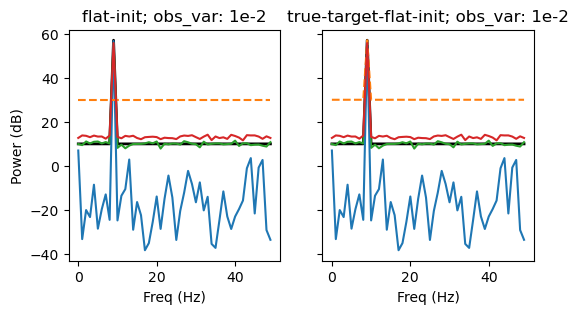

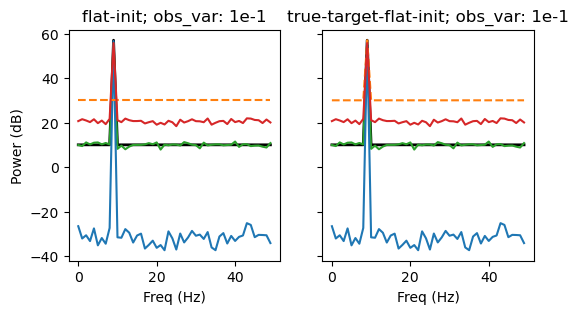

In [19]:
# ovs_sel = [-3, -1]
# ovs = [-3, -1]
dB = True
# ov = -1
init = inits[0]
res_to_plot_flat = load_results(res_paths, ovs_sel=ovs_sel, init=init, emiters=emiters, supp=supp, scale_init=scale_init)
init = inits[1]
res_to_plot_true_target = load_results(res_paths, ovs_sel=ovs_sel, L=L, init=init, emiters=emiters, supp=supp, scale_init=scale_init)
# for ov in ovs:
for ov in [-2, -1]:
    fshow = freqs[nz_fit50] <= 50
    fig, ax = plt.subplots(1,2,figsize=(6,3), sharey=True)
    # fig, ax = plt.subplots()
    plot_result_allfreqs(ax[0], res_to_plot_flat[ov], db=dB, fshow=fshow)
    plot_result_allfreqs(ax[1], res_to_plot_true_target[ov], db=dB, fshow=fshow)
    ax[0].set_title(f'flat-init; obs_var: 1e{ov}')
    ax[1].set_title(f'true-target-flat-init; obs_var: 1e{ov}')
    ax[0].set_xlabel('Freq (Hz)')
    ax[1].set_xlabel('Freq (Hz)')
    if dB is True:
        ax[0].set_ylabel('Power (dB)')
    else:
        ax[0].set_ylabel('Power')

    # ax.set_ylim([0,20000])
    if ov == -3:
        ax[0].legend()


In [20]:
res_paths = ['/projectnb/stephenlab/jtauber/cohlib/hydra/batch_submit/outputs/2024-08-07']

In [21]:
def plot_result_allfreqs(ax, res1, db, fshow, res2=None, k=0, leg=False, show_naive=True):
    gamma_init = res1['gamma_init']
    gamma_true_full= res1['gamma_true_full']

    m1_nz = res1['gamma']
    nz_m1 = jnp.arange(m1_nz.shape[0])
    gamma_true = gamma_true_full[nz_m1,:,:]


    m1 = jnp.zeros_like(gamma_true)
    gamma_model_m1 = m1.at[nz_m1,:,:].set(m1_nz)

    gamma_oracle, gamma_naive = compute_naive_and_oracle(res1['cfg'])

    gamma_oracle = gamma_oracle[nz_m1,:,:]
    gamma_naive = gamma_naive[nz_m1,:,:]

    # print(gamma_true)
    S_true = pow(gamma_true, k, db, fshow)
    S_init = pow(gamma_init, k, db, fshow)
    # print(S_true)
    S_oracle = pow(gamma_oracle, k, db, fshow)
    S_naive = pow(gamma_naive, k, db, fshow)
    S_model_m1 = pow(gamma_model_m1, k, db, fshow)


    # ax.plot(S_true, 'k', linewidth=2, label='True')
    # ax.plot(S_init, 'tab:orange', linestyle='--', label='Init')
    # if show_naive:
    #     ax.plot(S_naive, 'tab:red', label='Naive')
    # if res2 is not None:
    #     m2_nz = res_m2['gamma']
    #     m2 = jnp.zeros_like(gamma_true)
    #     gamma_model_m2 = m2.at[nz,:,:].set(m2_nz)
    #     S_model_m2 = pow(gamma_model_m2, k, db, fshow)
    #     ax.plot(S_model_m2, 'tab:green', label='Model2')

    ax.plot(S_oracle, 'tab:green', linewidth=3, label='Oracle')
    ax.plot(S_model_m1, 'tab:blue', linewidth=2, linestyle='--', label='Model')

    if leg == True:
        ax.legend()

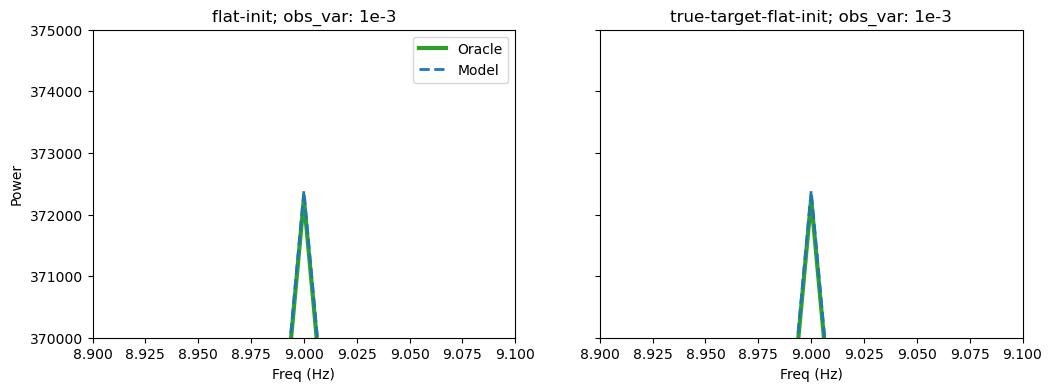

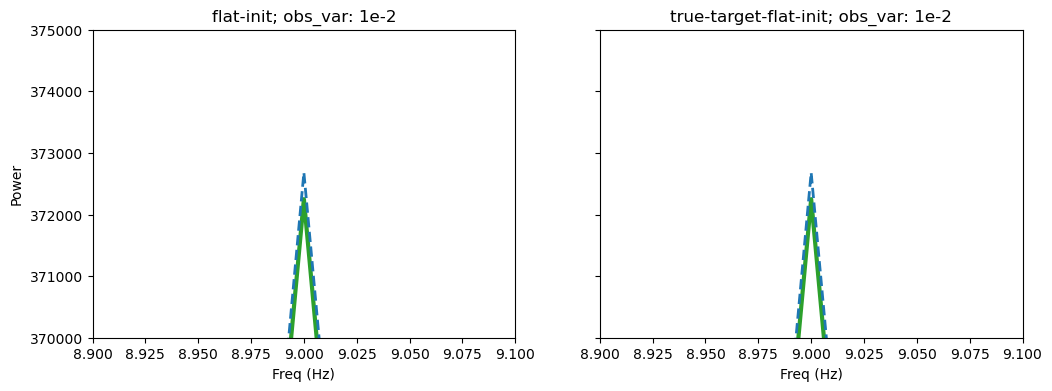

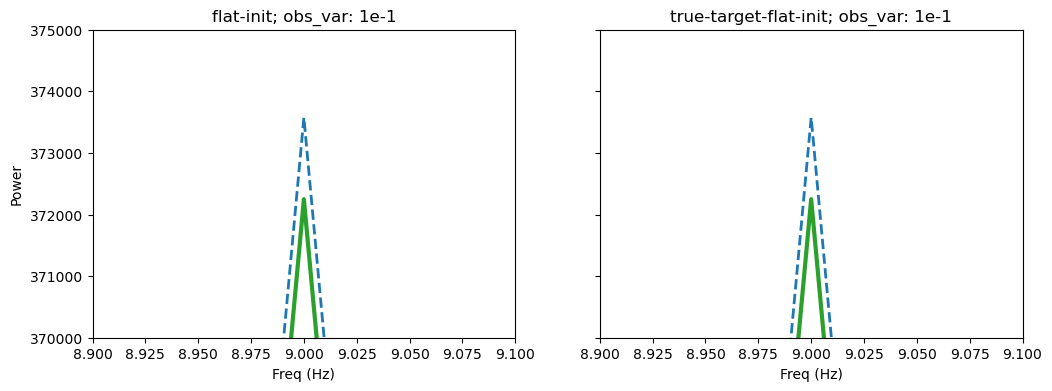

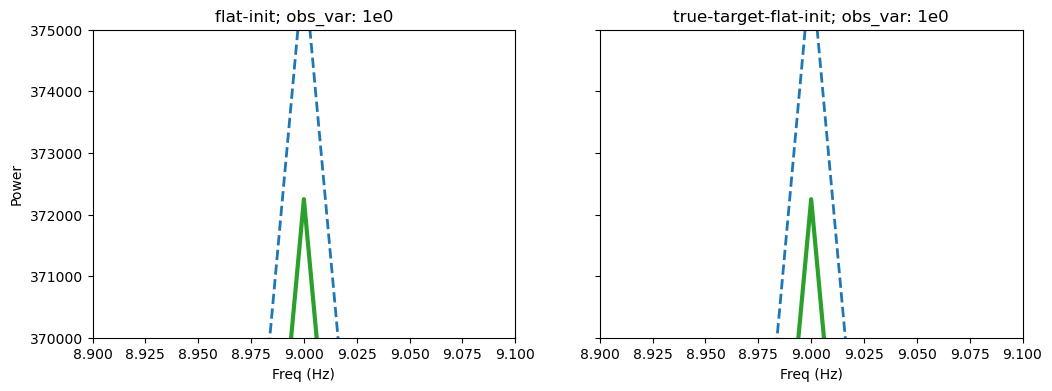

In [22]:

# ovs_sel = [-3, -1]
# ovs = [-3, -1]
llim = 370000
hlim = 375000
dB = False
# ov = -1
init = inits[0]
res_to_plot_flat = load_results(res_paths, ovs_sel=ovs_sel, init=init, emiters=emiters, supp=supp, scale_init=scale_init)
init = inits[1]
res_to_plot_true_target = load_results(res_paths, ovs_sel=ovs_sel, L=L, init=init, emiters=emiters, supp=supp, scale_init=scale_init)
# for ov in [-2, -1]:
for ov in ovs:
    fshow = freqs[nz_fit50] <= 50
    fig, ax = plt.subplots(1,2,figsize=(12,4), sharey=True)
    # fig, ax = plt.subplots()
    plot_result_allfreqs(ax[0], res_to_plot_flat[ov], db=dB, fshow=fshow)
    plot_result_allfreqs(ax[1], res_to_plot_true_target[ov], db=dB, fshow=fshow)
    ax[0].set_title(f'flat-init; obs_var: 1e{ov}')
    ax[1].set_title(f'true-target-flat-init; obs_var: 1e{ov}')
    ax[0].set_xlabel('Freq (Hz)')
    ax[1].set_xlabel('Freq (Hz)')
    if dB is True:
        ax[0].set_ylabel('Power (dB)')
    else:
        ax[0].set_ylabel('Power')

    # ax.set_ylim([0,20000])
    if ov == -3:
        ax[0].legend()
    ax[0].set_ylim([llim,hlim])
    ax[1].set_ylim([llim,hlim])
    ax[0].set_xlim([8.9,9.1])
    ax[1].set_xlim([8.9,9.1])


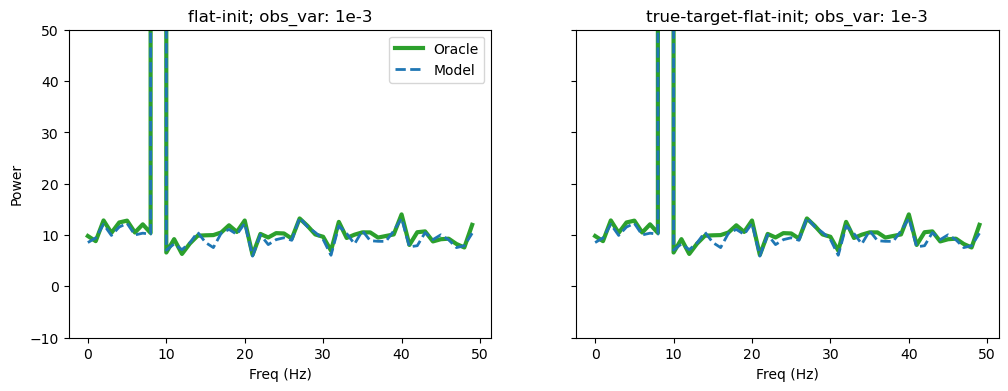

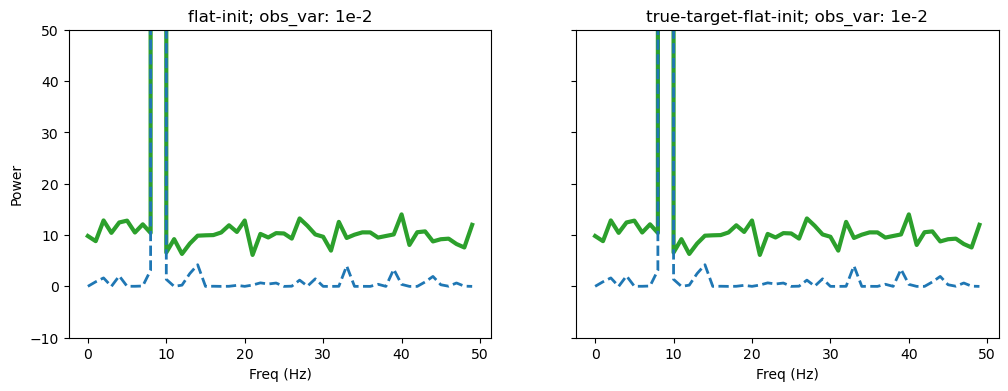

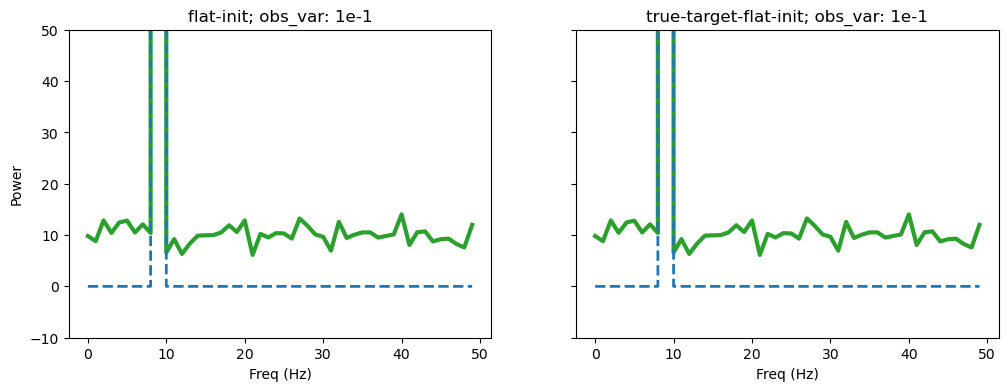

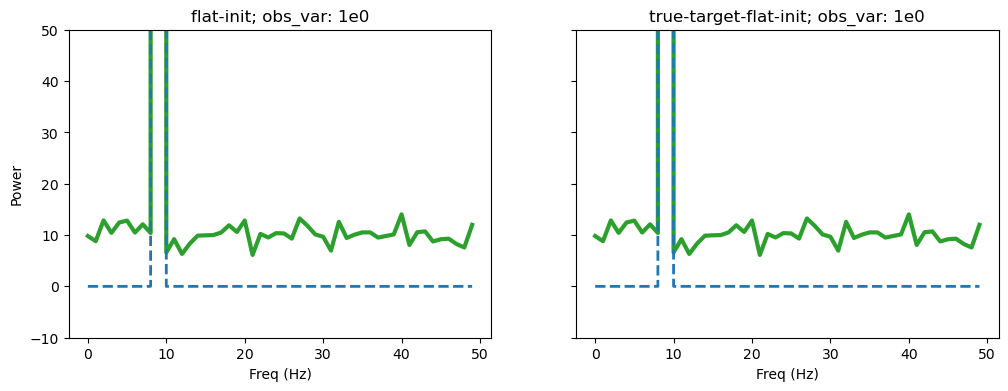

In [52]:
# ovs_sel = [-3, -1]
# ovs = [-3, -1]
llim = -10
hlim = 50
dB = False
# ov = -1
init = inits[0]
res_to_plot_flat = load_results(res_paths, ovs_sel=ovs_sel, init=init, emiters=emiters, supp=supp, scale_init=scale_init)
init = inits[1]
res_to_plot_true_target = load_results(res_paths, ovs_sel=ovs_sel, L=L, init=init, emiters=emiters, supp=supp, scale_init=scale_init)
# for ov in [-2, -1]:
for ov in ovs:
    fshow = freqs[nz_fit50] <= 50
    fig, ax = plt.subplots(1,2,figsize=(12,4), sharey=True)
    # fig, ax = plt.subplots()
    plot_result_allfreqs(ax[0], res_to_plot_flat[ov], db=dB, fshow=fshow)
    plot_result_allfreqs(ax[1], res_to_plot_true_target[ov], db=dB, fshow=fshow)
    ax[0].set_title(f'flat-init; obs_var: 1e{ov}')
    ax[1].set_title(f'true-target-flat-init; obs_var: 1e{ov}')
    ax[0].set_xlabel('Freq (Hz)')
    ax[1].set_xlabel('Freq (Hz)')
    if dB is True:
        ax[0].set_ylabel('Power (dB)')
    else:
        ax[0].set_ylabel('Power')

    # ax.set_ylim([0,20000])
    if ov == -3:
        ax[0].legend()
    ax[0].set_ylim([llim,hlim])
    ax[1].set_ylim([llim,hlim])


In [35]:
len(res1)

4

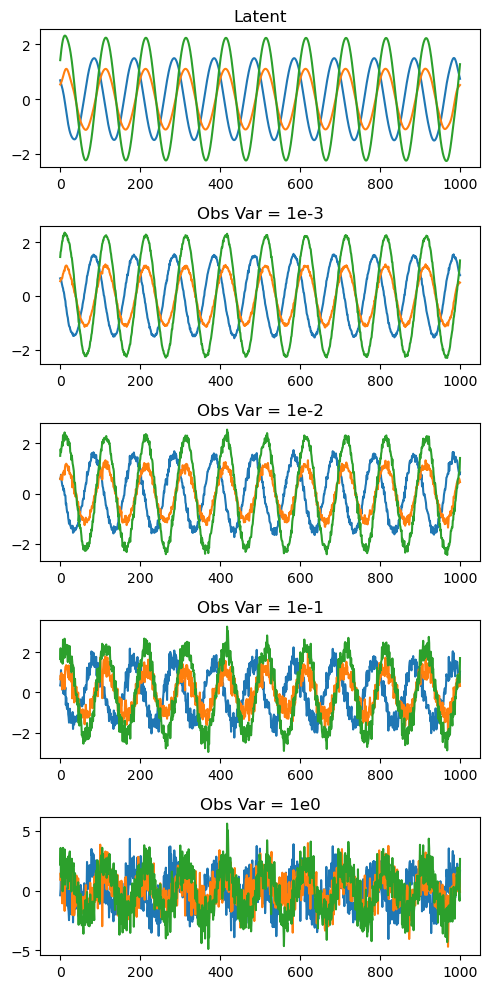

In [43]:
def plot_data_vars(res_dict, k=0):

    num_plots = len(res_dict) + 1
    fig, ax = plt.subplots(num_plots,1,figsize=(5,num_plots*2))

    for i, v in enumerate(sorted(list(res_dict.keys()))):
        res = res_dict[v]
        if i == 0:
            gamma_true_full = res['gamma_true_full']
            lcfg = res['cfg'].latent
            ocfg = res['cfg'].obs

            lrk = jr.key(lcfg.seed)
            zs = sample_from_gamma(lrk, gamma_true_full, lcfg.L)

            zs_0dc = jnp.apply_along_axis(add0, 0, zs)
            xs = jnp.fft.irfft(zs_0dc, axis=0)
            lcfg = res['cfg'].latent
            ocfg = res['cfg'].obs

            ork = jr.key(ocfg.seed)
            obs_var = ocfg.ov1 * 10**ocfg.ov2
            obs = xs + jr.normal(ork, xs.shape)*jnp.sqrt(obs_var)

            for l in range(3):
                ax[0].plot(xs[:,k,l])
                ax[1].plot(obs[:,k,l])
            ax[0].set_title('Latent')
            ax[1].set_title(f'Obs Var = 1e{ocfg.ov2}')
        else:
            lcfg = res['cfg'].latent
            ocfg = res['cfg'].obs

            ork = jr.key(ocfg.seed)
            obs_var = ocfg.ov1 * 10**ocfg.ov2
            obs = xs + jr.normal(ork, xs.shape)*jnp.sqrt(obs_var)

            for l in range(3):
                ax[i+1].plot(obs[:,k,l])
            ax[i+1].set_title(f'Obs Var = 1e{ocfg.ov2}')
        plt.tight_layout()

plot_data_vars(res1, k=0)

In [164]:
curr_paths = ['/projectnb/stephenlab/jtauber/cohlib/hydra/batch_submit/outputs/2024-08-05']
ov = -1

# init = 'flat-init'
# scale_init = 100 

init = 'flat-init'
scale_init = 0.1
# scale_init = 10
# scale_init = 1000

res1 = load_results(curr_paths, L=L, init=init, emiters=emiters, supp=supp, scale_init=scale_init)
cfg = res1[ov]['cfg']
obs = gen_k2full10_data(cfg)
obs_var = 10**ov

In [165]:
Qs = []
track = res1[ov]['track']
for r in range(len(track['gamma'])): 
    gamma_r = track['gamma'][r]
    mus_r = track['mus'][r]
    Q_r = calc_Q(gamma_r, mus_r, nz, obs, obs_var)
    Qs.append(Q_r)

Text(0, 0.5, 'Q')

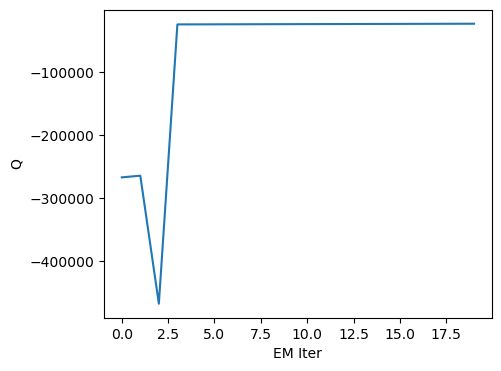

In [166]:
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(Qs)
ax.set_xlabel('EM Iter')
ax.set_ylabel('Q')

In [150]:
def calc_Q(gamma_est, mus_est, nz, data, obs_var):
    T = data.shape[0]
    N = int(T/2)
    L = data.shape[-1]
    Nnz = gamma_est.shape[0]
    K = gamma_est.shape[1]

    zs_est = jnp.zeros((N,K,L), dtype=complex)
    zs_est = zs_est.at[nz,:,:].set(mus_est)
    zs_est_0dc = jnp.apply_along_axis(add0, 0, zs_est)
    xs_est = jnp.fft.irfft(zs_est_0dc, axis=0)
    yyT = jnp.einsum('tkl,ikl->tikl', data, data)
    yxT = jnp.einsum('tkl,ikl->tikl', data, xs_est)
    xyT = jnp.einsum('tkl,ikl->tikl', xs_est, data)
    xxT = jnp.einsum('tkl,ikl->tikl', xs_est, xs_est)
    Q_obs_sum = yyT - yxT - xyT + xxT

    a = -(T/2)*(jnp.log(2*jnp.pi) + jnp.log(obs_var))
    Q_obs_sum = yyT - yxT - xyT + xxT
    b = -(1/2)*jnp.trace(Q_obs_sum, axis1=0, axis2=1).sum()*(1/obs_var)

    c = -( (Nnz*K)*jnp.log(jnp.pi) + jnp.log(jnp.linalg.det(gamma_est).real).sum() )
    gamma_est_inv = jnp.linalg.inv(gamma_est)
    gamma_est_inv_full = jnp.zeros((N,K,K), dtype=complex)
    gamma_est_inv_full = gamma_est_inv_full.at[nz,:,:].set(gamma_est_inv)

    zs_est_outer = jnp.einsum('jkl,jil->jkil', zs_est, zs_est.conj())
    # print(zs_est_outer.shape)
    temp = jnp.einsum('jki,jinl->jknl', gamma_est_inv_full, zs_est_outer)
    d = -jnp.trace(temp, axis1=1, axis2=2).real.sum()
    Q_val = a + b + c + d

    return Q_val

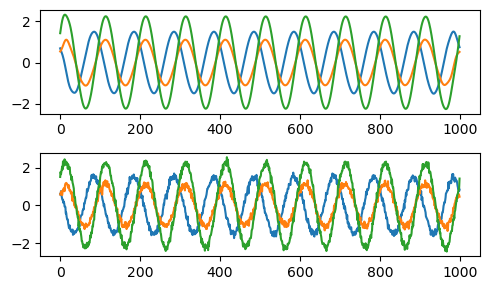

In [66]:
plot_data(res1[ov])

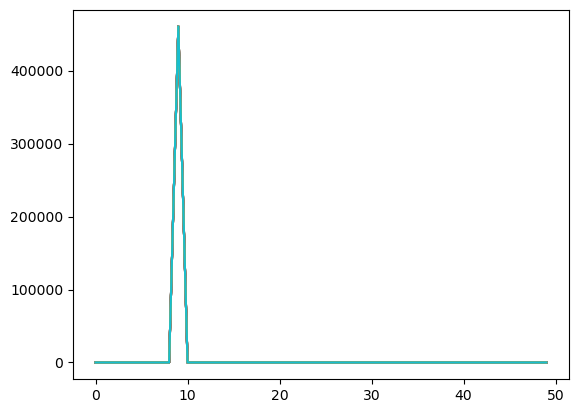

In [73]:
k = 0

ov = -2
dB = False
# plt.plot(res1[ov]['gamma_true_full'][:50,0,0].real, color='k')
# plt.plot(res1[ov]['gamma_init'][:50,k,k].real, color='k')
for r in range(emiters):
    gamma_r = res1[ov]['track']['gamma'][r]
    S = gamma_r[:,k,k].real
    if dB is True:
        S = 10*jnp.log10(S)
    plt.plot(S)

10
50
100
1000


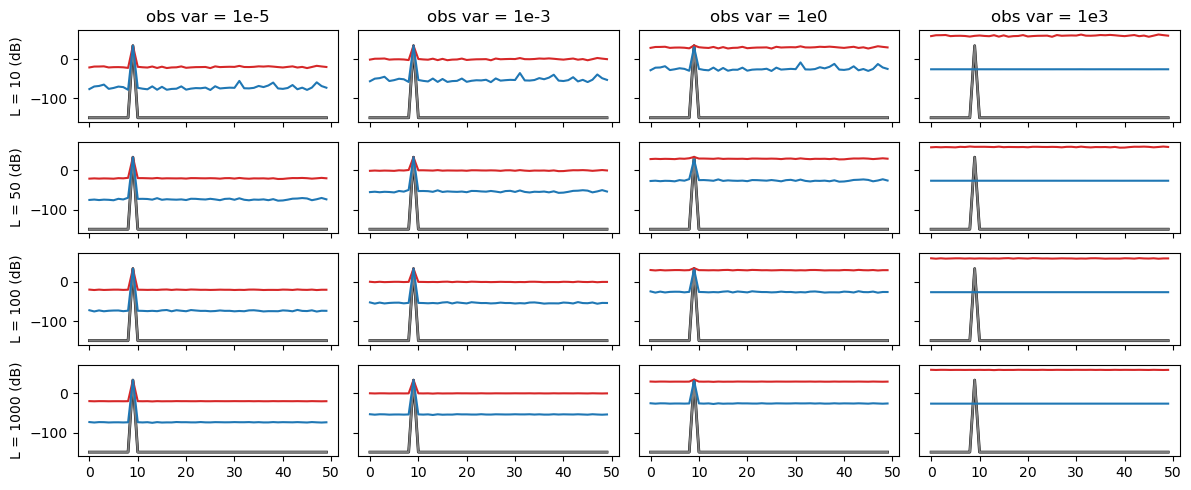

In [72]:
# emiters = '20'
dB = True
fig, ax = plt.subplots(3,2,figsize=(8,5),sharex=True, sharey=True)
# fig, ax = plt.subplots(4,4,figsize=(12,5))
# obs_vars = res_l.keys()
# Ls = [10,50,100,1000]

fshow = freqs <= 50
scale_inits = [1, 10, 50]
ov = -1
for i, si in enumerate(scale_inits):
    supp = [0, 50]
    init = 'true-init'
    res_true_init = load_results(res_paths, L=L, init=init, emiters=emiters, supp=supp, scale_init=si)
    plot_result_allfreqs(ax[i,0], res_true_init[ov], db=dB, fshow=fshow)

    init = 'flat-init'
    res_flat_init = load_results(res_paths, L=L, init=init, emiters=emiters, supp=supp, scale_init=si)



    # for j, ov2 in enumerate(ovs):
    #     plot_result_allfreqs(ax[i,j], res_fit50[ov2], res_single[ov2], db=dB, fshow=fshow)
    #     if dB is False:
    #         ax[i,0].set_ylabel(f'L = {L}')
    #     else:
    #         ax[i,0].set_ylabel(f'L = {L} (dB)')
    #     ax[0,j].set_title(f'obs var = 1e{ov2}')
        # ax[i,j].set_ylim([-30,50])
plt.tight_layout()


10
50
100
1000


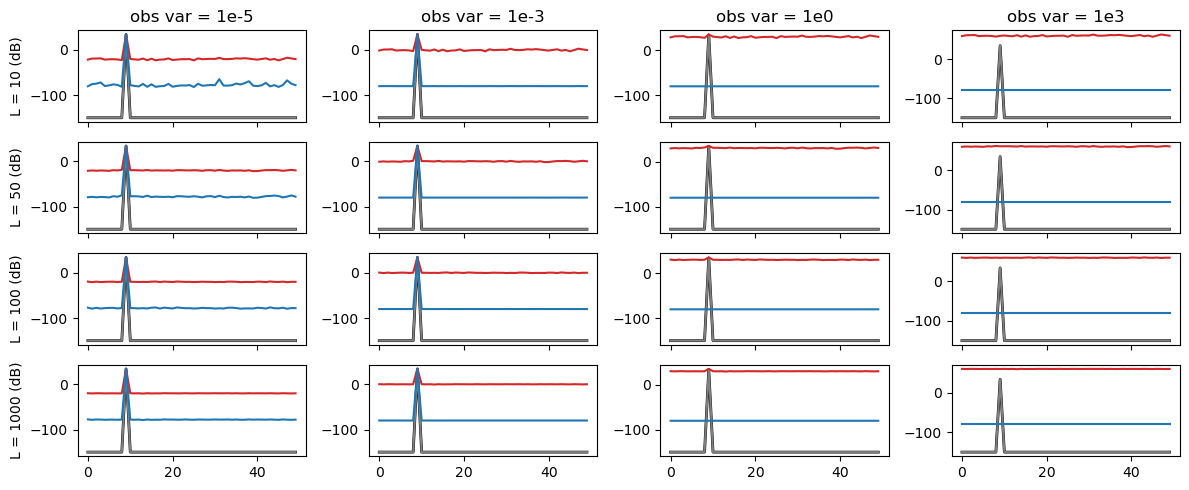

In [ ]:
init = 'flat-init'
# emiters = '20'
dB = True
fig, ax = plt.subplots(4,4,figsize=(12,5),sharex=True)
# fig, ax = plt.subplots(4,4,figsize=(12,5))
# obs_vars = res_l.keys()
Ls = [10,50,100,1000]
for i, L in enumerate(Ls):
    supp = [0, 50]
    res_fit50 = load_results(res_paths, L=L, init=init, emiters=emiters, supp=supp)
    supp = None
    res_single = load_results(res_paths, L=L, init=init, emiters=emiters, supp=supp)
    print(L)
    # print(res_fit50.keys())
    for j, ov2 in enumerate(ovs):
        plot_result_allfreqs(ax[i,j], res_fit50[ov2], res_single[ov2], db=dB, fshow=fshow)
        if dB is False:
            ax[i,0].set_ylabel(f'L = {L}')
        else:
            ax[i,0].set_ylabel(f'L = {L} (dB)')
        ax[0,j].set_title(f'obs var = 1e{ov2}')
        # ax[i,j].set_ylim([-30,50])
plt.tight_layout()


10
50
100
1000


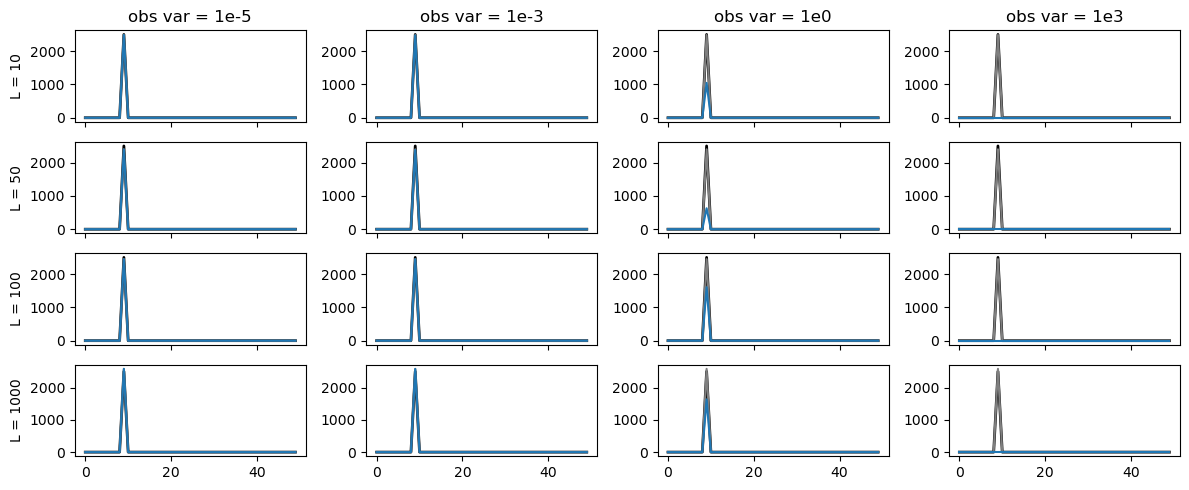

In [85]:
init = 'true-init'
# emiters = '20'
dB = False
fig, ax = plt.subplots(4,4,figsize=(12,5),sharex=True)
# fig, ax = plt.subplots(4,4,figsize=(12,5))
# obs_vars = res_l.keys()
Ls = [10,50,100,1000]
for i, L in enumerate(Ls):
    supp = [0, 50]
    res_fit50 = load_results(res_paths, L=L, init=init, emiters=emiters, supp=supp)
    supp = None
    res_single = load_results(res_paths, L=L, init=init, emiters=emiters, supp=supp)
    print(L)
    # print(res_fit50.keys())
    for j, ov2 in enumerate(ovs):
        plot_result_allfreqs(ax[i,j], res_fit50[ov2], res_single[ov2], db=dB, fshow=fshow)
        if dB is False:
            ax[i,0].set_ylabel(f'L = {L}')
        else:
            ax[i,0].set_ylabel(f'L = {L} (dB)')
        ax[0,j].set_title(f'obs var = 1e{ov2}')
        # ax[i,j].set_ylim([-30,50])
plt.tight_layout()


10
50
100
1000


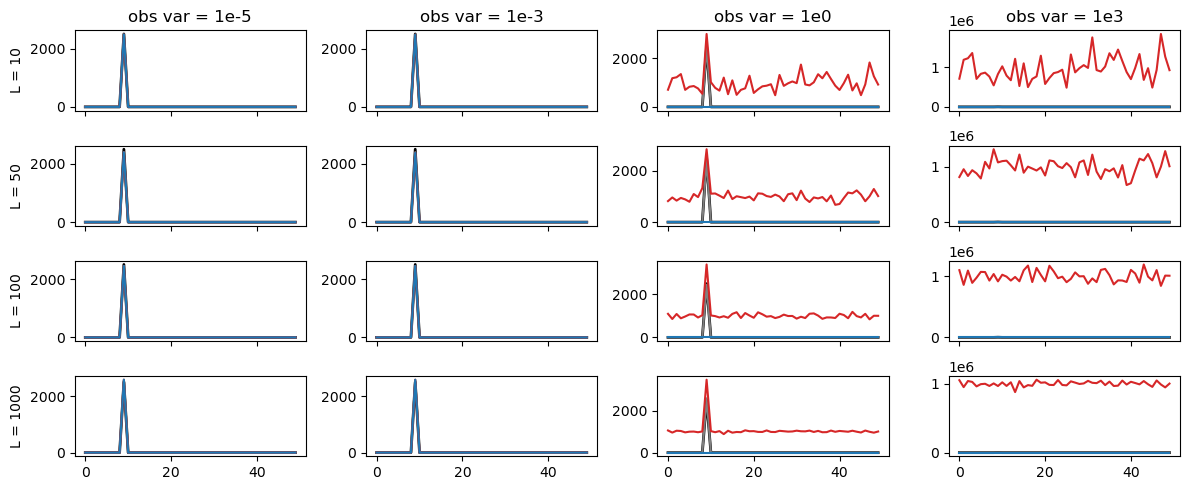

In [90]:
init = 'flat-init'
# emiters = '20'
dB = False
fig, ax = plt.subplots(4,4,figsize=(12,5),sharex=True)
# fig, ax = plt.subplots(4,4,figsize=(12,5))
# obs_vars = res_l.keys()
Ls = [10,50,100,1000]
for i, L in enumerate(Ls):
    supp = [0, 50]
    res_fit50 = load_results(res_paths, L=L, init=init, emiters=emiters, supp=supp)
    supp = None
    res_single = load_results(res_paths, L=L, init=init, emiters=emiters, supp=supp)
    print(L)
    # print(res_fit50.keys())
    for j, ov2 in enumerate(ovs):
        plot_result_allfreqs(ax[i,j], res_fit50[ov2], res_single[ov2], db=dB, fshow=fshow)
        if dB is False:
            ax[i,0].set_ylabel(f'L = {L}')
        else:
            ax[i,0].set_ylabel(f'L = {L} (dB)')
        ax[0,j].set_title(f'obs var = 1e{ov2}')
        # ax[i,j].set_ylim([-30,50])
plt.tight_layout()


10
[[2.4836345e+03]
 [2.4742527e+03]
 [1.1457424e+03]
 [2.4517105e+00]]
50
[[2396.9158  ]
 [2377.5095  ]
 [ 889.6229  ]
 [   2.456655]]
100
[[2447.9285  ]
 [2448.3994  ]
 [1628.4907  ]
 [   2.453137]]
1000
[[2.5794004e+03]
 [2.5764368e+03]
 [1.6694603e+03]
 [2.4542716e+00]]


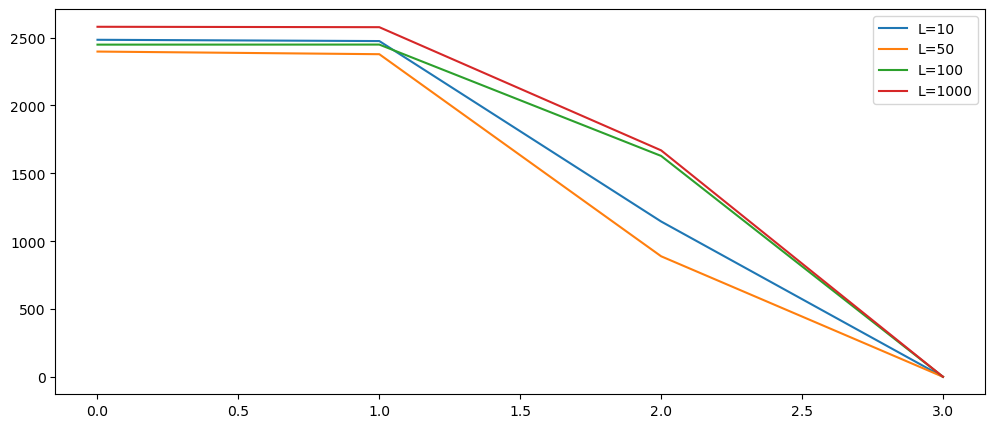

In [250]:
tind = nz
dB = False
fig, ax = plt.subplots(figsize=(12,5))
# obs_vars = res_l.keys()
S_true = gamma_full[tind,0,0].real
for i, L in enumerate(Ls):
    print(L)
    res_l = load_results(L, 'true-init')
    S_ests = []
    for j, ov in enumerate(ovs):
        gamma_est = res_l[ov]['gamma']
        gamma_est_full = jnp.zeros_like((gamma_full))
        gamma_est_full = gamma_est_full.at[nz,:,:].set(gamma_est)
        S_est = gamma_est_full[tind,0,0].real
        S_ests.append(S_est)
    S_ests = jnp.array(S_ests)
    if dB is False:
        ax.plot(S_ests, label=f'L={L}')
    else:
        ax.plot(10*jnp.log10(S_ests.real), label=f'L={L}')
    print(S_ests.real)
    ax.legend()
    
    #     if dB is False:
    #         ax[i,j].plot(S_true, 'k')
    #         ax[i,j].plot(S_est)
    #     else:
    #         ax[i,j].plot(10*jnp.log10(S_true+1e-15), 'k')
    #         ax[i,j].plot(10*jnp.log10(S_est+1e-15))
    #     ax[0,j].set_title(f'obs var = 1e{ov}')
    #     ax[i,0].set_ylabel(f'L = {L}')
    #     # ax[i,j].set_ylim([-30,50])
    # plt.tight_layout()


In [200]:
# next - check flat init on low variance and then run
# after that - add low-var up to 50 hz
gamma_path = os.path.join(gamma_root(), f"{lcfg.gamma}.pickle")
gamma_load = pickle_open(gamma_path)

gamma_full = gamma_load['gamma']
freqs = gamma_load['freqs']
nz = gamma_load['nonzero_inds']

gamma_full *= lcfg.scale

lrk = jr.key(lcfg.seed)
zs = sample_from_gamma(lrk, gamma_full, lcfg.L)
zs_0dc = jnp.apply_along_axis(add0, 0, zs)
xs = jnp.fft.irfft(zs_0dc, axis=0)

ork = jr.key(ocfg.seed)
obs_var = ocfg.ov1 * 10**ocfg.ov2
obs = xs + jr.normal(ork, xs.shape)*jnp.sqrt(obs_var)

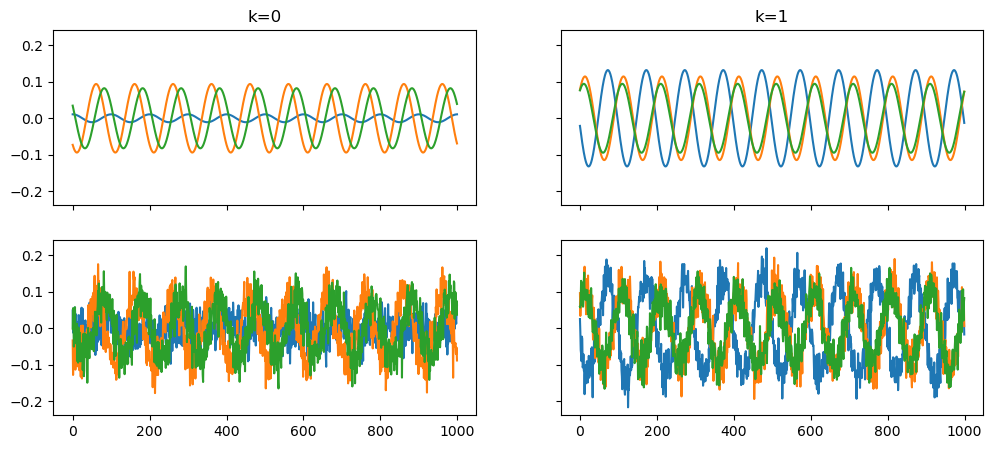

In [49]:
lig, ax = plt.subplots(2,2,figsize=(12,5), sharex=True, sharey=True)
for l in range(3):
    for k in range(2):
        ax[0,k].plot(xs[:,k,l])
        ax[1,k].plot(obs[:,k,l])
        if l == 0:
            ax[0,k].set_title(f'k={k}')
            ax[0,0].set_ylabel('')